In [2]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.structures import BoxMode
from detectron2.utils.visualizer import ColorMode
import matplotlib.pyplot as plt

In [22]:
import os
import json
import cv2

def convert_odgt_to_coco_json(odgt_file, img_dir, output_json):
    coco_data = {
        "images": [],
        "annotations": [],
        "categories": [{"id": 1, "name": "person"}]  # Definisci la categoria "person" con id = 1
    }

    annotation_id = 1  # Per tenere traccia degli ID delle annotazioni univoche

    with open(odgt_file, 'r') as f:
        for idx, line in enumerate(f):
            data = json.loads(line.strip())

            # Dati dell'immagine
            image_info = {
                "file_name": f"{data['ID']}.jpg",  # Assumi che 'ID' corrisponda al nome del file immagine
                "id": idx,  # L'id dell'immagine
                "height": None,  # Lo aggiorneremo dopo
                "width": None    # Lo aggiorneremo dopo
            }

            # Percorso completo dell'immagine
            img_path = os.path.join(img_dir, image_info["file_name"])

            # Usa OpenCV per ottenere altezza e larghezza dell'immagine
            height, width = cv2.imread(img_path).shape[:2]
            image_info["height"] = height
            image_info["width"] = width

            coco_data["images"].append(image_info)

            # Annota le box per ogni immagine
            for obj in data['gtboxes']:
                bbox = obj['fbox']  # Il bounding box in formato [x_min, y_min, width, height]
                x_min, y_min, box_width, box_height = bbox
                x_max = x_min + box_width
                y_max = y_min + box_height

                annotation_info = {
                    "id": annotation_id,  # ID univoco per ogni annotazione
                    "image_id": idx,  # Collegato all'immagine corrente
                    "category_id": 1,  # 'person' ha id = 1
                    "bbox": [x_min, y_min, box_width, box_height],
                    "bbox_mode": 1,  # BoxMode.XYWH_ABS, nel formato COCO usa [x_min, y_min, width, height]
                    "area": box_width * box_height,  # Area del bounding box
                    "iscrowd": 0  # 0 = non crowd, 1 = crowd
                }

                coco_data["annotations"].append(annotation_info)
                annotation_id += 1

    # Scrivi il risultato in formato JSON
    with open(output_json, 'w') as output_file:
        json.dump(coco_data, output_file, indent=4)

    print(f"Conversione completata! Il file JSON è stato salvato in: {output_json}")


# Esegui la conversione (specifica il tuo file .odgt e l'output desiderato)
input_odgt = "human/train/annotation_train.odgt"
img_dir = "human/train"  # Directory delle immagini
output_json = "human/train/annotation_train.json"
convert_odgt_to_coco_json(input_odgt, img_dir,output_json)


input_odgt = "human/validation/annotation_val.odgt"
img_dir = "human/validation"  # Directory delle immagini
output_json = "human/validation/annotation_val.json"
convert_odgt_to_coco_json(input_odgt, img_dir ,output_json)

Conversione completata! Il file JSON è stato salvato in: human/train/annotation_train.json
Conversione completata! Il file JSON è stato salvato in: human/validation/annotation_val.json


In [31]:
DatasetCatalog.clear()  # Clear the existing registrations
MetadataCatalog.clear()  # Clear the metadata as well

register_coco_instances("human_train", {}, "human/train/annotation_train.json", "human/train")
register_coco_instances("human_val", {}, "human/validation/annotation_val.json", "human/validation")

human_metadata = MetadataCatalog.get("human_train")



In [33]:
import json
import os
from detectron2.structures import BoxMode

def get_coco_dicts(json_file, img_dir):
    with open(json_file) as f:
        coco_data = json.load(f)

    dataset_dicts = []

    for image_info in coco_data["images"]:
        record = {}
        record["file_name"] = os.path.join(img_dir, image_info["file_name"])
        record["image_id"] = image_info["id"]
        record["height"] = image_info["height"]
        record["width"] = image_info["width"]

        objs = []
        for ann in coco_data["annotations"]:
            if ann["image_id"] == image_info["id"]:
                obj = {
                    "bbox": ann["bbox"],
                    "bbox_mode": BoxMode.XYWH_ABS,  # COCO usa XYWH (x, y, width, height)
                    "category_id": ann["category_id"],
                    "iscrowd": ann.get("iscrowd", 0)
                }
                objs.append(obj)

        record["annotations"] = objs
        dataset_dicts.append(record)

    return dataset_dicts


In [37]:
train_dicts = get_coco_dicts("human/train/annotation_train.json","human/train")

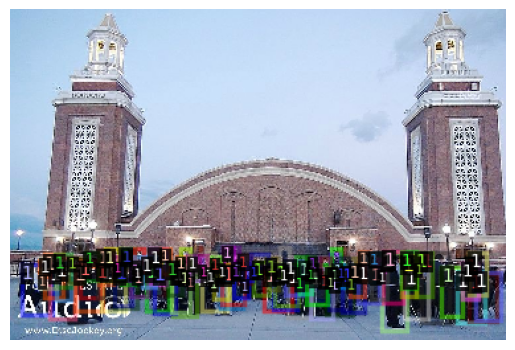

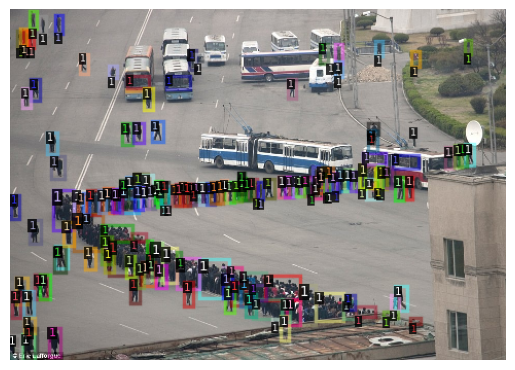

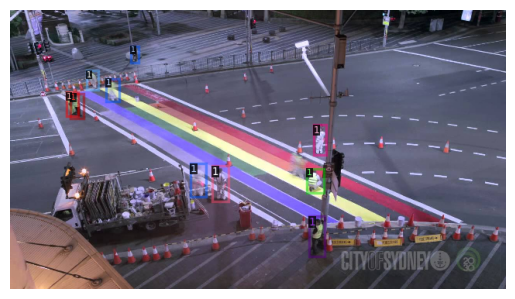

In [38]:
for d in random.sample(train_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=human_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    # Convert the image from BGR (OpenCV format) to RGB (Matplotlib format)
    img_rgb = cv2.cvtColor(out.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB)

    # Display the image using Matplotlib
    plt.imshow(img_rgb)
    plt.axis('off')  # Turn off axis ticks and labels
    plt.show()

In [60]:
cfg = get_cfg()
cfg.MODEL.DEVICE = "cpu"
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml"))
cfg.DATASETS.TRAIN = ("human_train",)
cfg.DATASETS.VAL = ("human_val",)
cfg.DATASETS.TEST = () 
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml") 
cfg.SOLVER.IMS_PER_BATCH = 2  
cfg.SOLVER.BASE_LR = 0.00025 
cfg.SOLVER.MAX_ITER = 300  # Increased iterations for COCO 
cfg.SOLVER.STEPS = []        
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  

In [61]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[10/21 15:20:42 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, we

[10/21 15:21:00 d2.engine.train_loop]: Starting training from iteration 0


python(31963) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(31964) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[10/21 15:25:58 d2.utils.events]:  eta: 1:02:58  iter: 19  total_loss: 1.758  loss_cls: 0.6144  loss_box_reg: 0.731  loss_rpn_cls: 0.1325  loss_rpn_loc: 0.1819    time: 14.6564  last_time: 11.4620  data_time: 0.2170  last_data_time: 0.0133   lr: 1.6068e-05  
[10/21 15:30:17 d2.utils.events]:  eta: 0:58:41  iter: 39  total_loss: 1.689  loss_cls: 0.5776  loss_box_reg: 0.7041  loss_rpn_cls: 0.1796  loss_rpn_loc: 0.2441    time: 13.7697  last_time: 16.7799  data_time: 0.0048  last_data_time: 0.0087   lr: 3.2718e-05  
[10/21 15:35:02 d2.utils.events]:  eta: 0:54:10  iter: 59  total_loss: 1.584  loss_cls: 0.4995  loss_box_reg: 0.772  loss_rpn_cls: 0.1482  loss_rpn_loc: 0.1828    time: 13.9267  last_time: 14.9160  data_time: 0.0088  last_data_time: 0.0066   lr: 4.9367e-05  
[10/21 15:40:36 d2.utils.events]:  eta: 0:51:59  iter: 79  total_loss: 1.572  loss_cls: 0.449  loss_box_reg: 0.7247  loss_rpn_cls: 0.1055  loss_rpn_loc: 0.2154    time: 14.6431  last_time: 13.6978  data_time: 0.0093  last_

In [62]:
%load_ext tensorboard
%tensorboard --logdir output

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 16112), started 18:11:27 ago. (Use '!kill 16112' to kill it.)

In [63]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[10/21 16:31:59 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


/Users/stefano_ruggiero/miniconda3/envs/detectron2/lib/python3.10/site-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.l

[10/21 16:32:03 d2.data.datasets.coco]: Loaded 4370 images in COCO format from human/validation/annotation_val.json


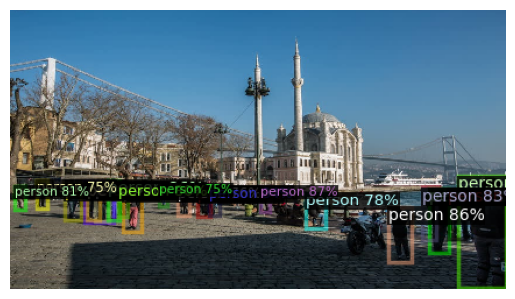

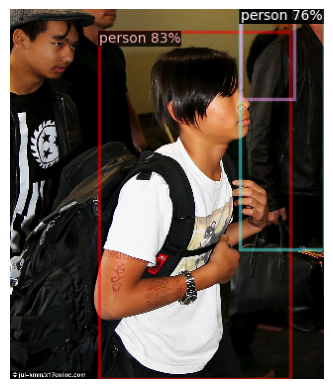

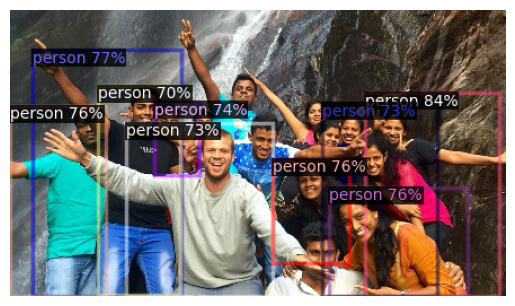

In [64]:
# Ottieni il dataset di validazione
dataset_dicts = DatasetCatalog.get("human_val")

# Loop attraverso 3 immagini casuali del dataset di convalida
for d in random.sample(dataset_dicts, 3):
    im = cv2.imread(d["file_name"])  # Carica l'immagine
    outputs = predictor(im)  # Fai le predizioni con il modello

    # Visualizza le predizioni come bounding box
    v = Visualizer(
        im[:, :, ::-1],  # Converti BGR (OpenCV) a RGB (Detectron2)
        metadata=human_metadata,  # Usa i metadati COCO
        scale=0.5,
        instance_mode=ColorMode.IMAGE  # Usa l'immagine a colori
    )
    
    # Disegna solo le predizioni dei bounding box
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    # Converti l'immagine da BGR (OpenCV) a RGB (Matplotlib)
    img_rgb = cv2.cvtColor(out.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB)

    # Visualizza l'immagine usando Matplotlib
    plt.imshow(img_rgb)
    plt.axis('off')  # Disabilita gli assi
    plt.show()


In [65]:
evaluator = COCOEvaluator("human_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "human_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

[10/21 16:32:20 d2.data.datasets.coco]: Loading human/validation/annotation_val.json takes 2.23 seconds.
[10/21 16:32:20 d2.data.datasets.coco]: Loaded 4370 images in COCO format from human/validation/annotation_val.json
[10/21 16:32:21 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[10/21 16:32:21 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[10/21 16:32:21 d2.data.common]: Serializing 4370 elements to byte tensors and concatenating them all ...
[10/21 16:32:21 d2.data.common]: Serialized dataset takes 4.76 MiB
[10/21 16:32:21 d2.evaluation.evaluator]: Start inference on 4370 batches


python(35049) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(35050) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[10/21 16:32:42 d2.evaluation.evaluator]: Inference done 11/4370. Dataloading: 0.0005 s/iter. Inference: 1.6759 s/iter. Eval: 0.0001 s/iter. Total: 1.6766 s/iter. ETA=2:01:48
[10/21 16:32:48 d2.evaluation.evaluator]: Inference done 14/4370. Dataloading: 0.0008 s/iter. Inference: 1.8018 s/iter. Eval: 0.0002 s/iter. Total: 1.8032 s/iter. ETA=2:10:54
[10/21 16:32:53 d2.evaluation.evaluator]: Inference done 17/4370. Dataloading: 0.0009 s/iter. Inference: 1.7678 s/iter. Eval: 0.0001 s/iter. Total: 1.7694 s/iter. ETA=2:08:22
[10/21 16:33:00 d2.evaluation.evaluator]: Inference done 21/4370. Dataloading: 0.0010 s/iter. Inference: 1.7360 s/iter. Eval: 0.0002 s/iter. Total: 1.7377 s/iter. ETA=2:05:57
[10/21 16:33:06 d2.evaluation.evaluator]: Inference done 24/4370. Dataloading: 0.0009 s/iter. Inference: 1.7725 s/iter. Eval: 0.0002 s/iter. Total: 1.7742 s/iter. ETA=2:08:30
[10/21 16:33:11 d2.evaluation.evaluator]: Inference done 27/4370. Dataloading: 0.0010 s/iter. Inference: 1.7640 s/iter. Eval: